#### Reference: https://www.proquest.com/docview/2557143230

## Illuatration

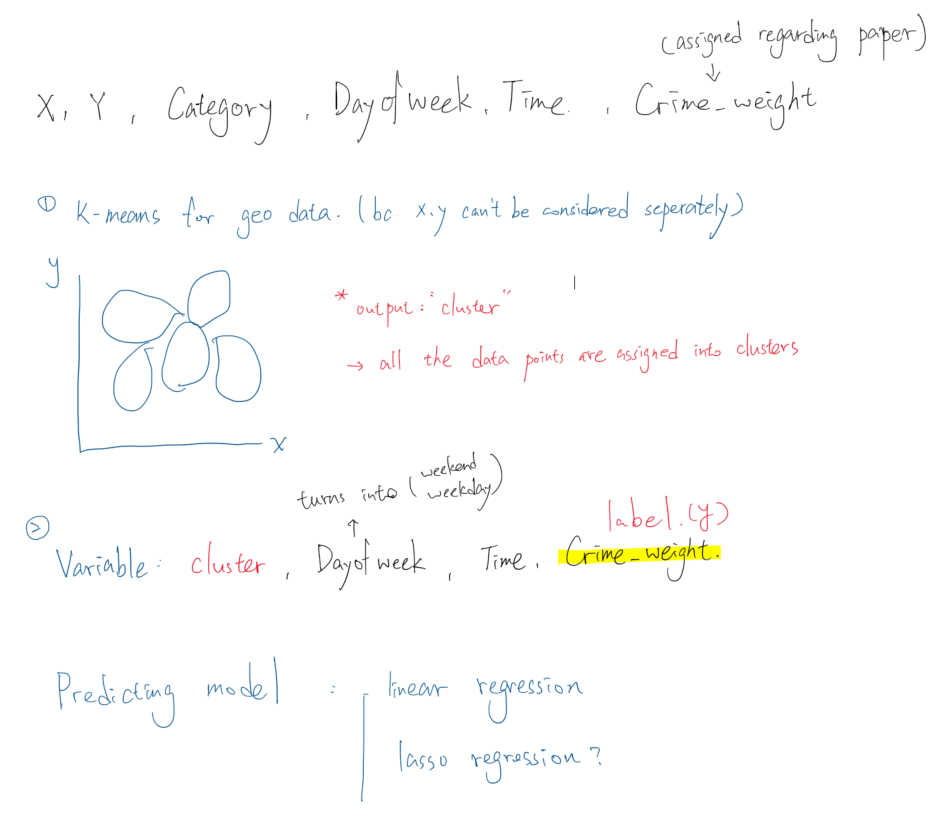
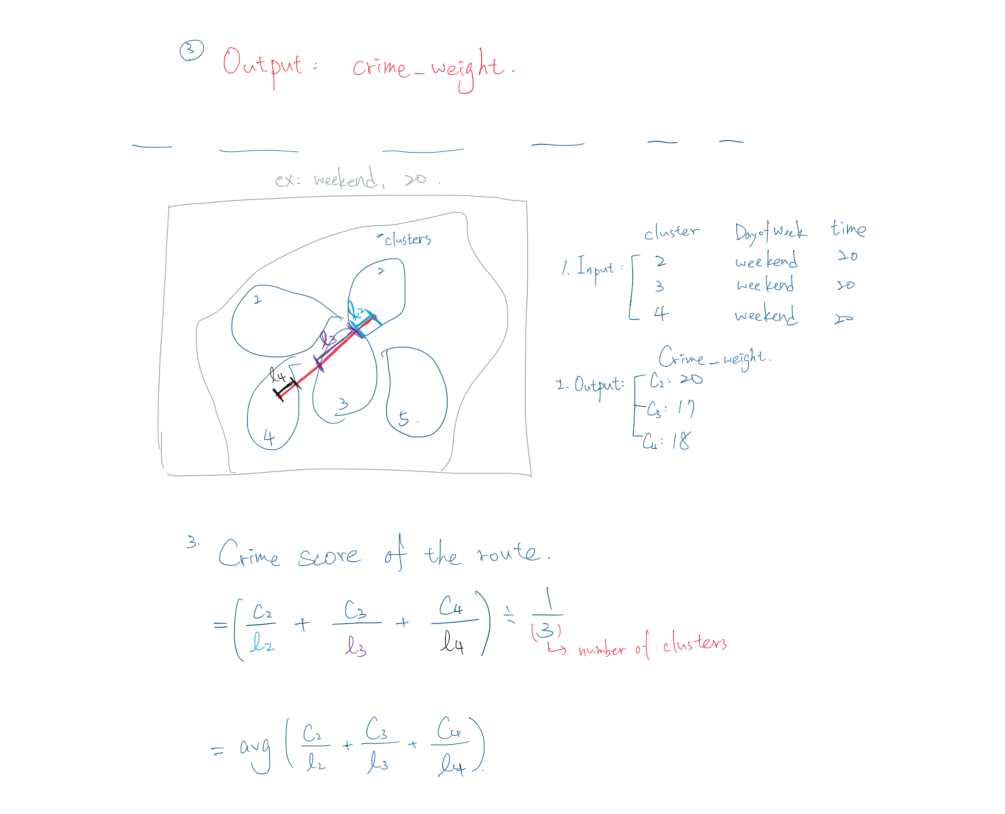

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('processed_data.csv', index_col=0)
df = df.reset_index(drop=True)

## K-means cluster for x, y

In [3]:
geo_df = df[['X', 'Y']]
geo_df

,X,Y
0,-122.409530,37.765718
1,-122.495225,37.753412
2,-122.475647,37.728528
3,-122.412652,37.779513
4,-122.466205,37.772541
...,...,...
294577,-122.404360,37.788273
294578,-122.422536,37.778796
294579,-122.405863,37.798023
294580,-122.403305,37.792728


In [4]:
# standardize
from sklearn.preprocessing import StandardScaler
s_geo_df = pd.DataFrame(StandardScaler().fit_transform(geo_df), columns=['X', 'Y'])
s_geo_df

,X,Y
0,0.539828,-0.194172
1,-2.765332,-0.726746
2,-2.010248,-1.803607
3,0.419417,0.402803
4,-1.646050,0.101059
...,...,...
294577,0.739242,0.781875
294578,0.038180,0.371762
294579,0.681249,1.203820
294580,0.779917,0.974665


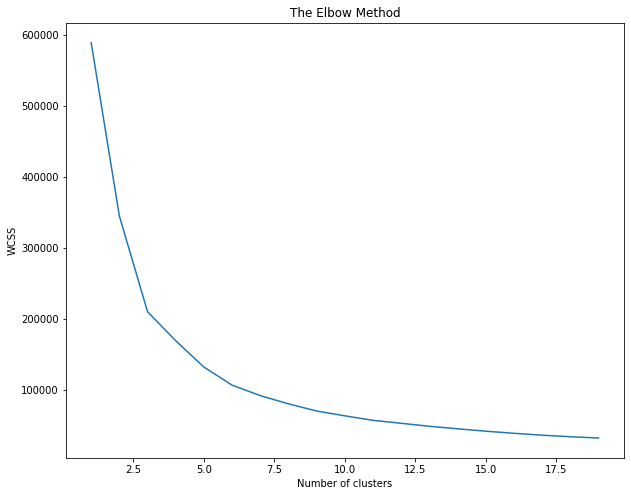

In [5]:
# elbow method (find the best number of clusters)
plt.figure(figsize=(10, 8))
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 1024)
    kmeans.fit(s_geo_df)
    wcss.append(kmeans.inertia_) #criterion based on which K-means clustering works
plt.plot(range(1, 20), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#### 6 clusters

In [6]:
# final model
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 1024)
cluster = kmeans.fit_predict(s_geo_df)

In [7]:
tmp_df = pd.DataFrame(cluster, columns=['cluster'])
result_df = pd.concat([geo_df,tmp_df], axis=1)
result_df

,X,Y,cluster
0,-122.409530,37.765718,2
1,-122.495225,37.753412,5
2,-122.475647,37.728528,0
3,-122.412652,37.779513,1
4,-122.466205,37.772541,5
...,...,...,...
294577,-122.404360,37.788273,1
294578,-122.422536,37.778796,1
294579,-122.405863,37.798023,1
294580,-122.403305,37.792728,1


C:\Users\tien2\anaconda3\envs\ml_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


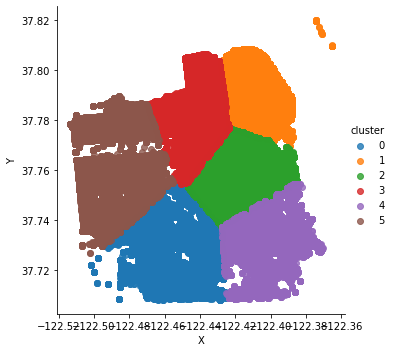

In [8]:
# visualization of the clusters
import seaborn as sns
sns.lmplot('X', 'Y', data=result_df, hue='cluster', fit_reg=False)

plt.show()

In [9]:
df = pd.concat([df,tmp_df], axis=1)

In [10]:
df.to_csv('clustered_data.csv')

## build the model for predicting crime score with cluster
- linear regression
- lasso regression

**cross validation(could do k-fold or leave-one-out)**

In [94]:
df = pd.read_csv('clustered_data.csv', index_col=0)

In [95]:
df = df[['DayOfWeek', 'Time', 'crime_weight', 'cluster']]
df[['cluster']] = df[['cluster']].astype(str)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294582 entries, 0 to 294581
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   DayOfWeek     294582 non-null  object
 1   Time          294582 non-null  int64 
 2   crime_weight  294582 non-null  int64 
 3   cluster       294582 non-null  object
dtypes: int64(2), object(2)
memory usage: 11.2+ MB


,DayOfWeek,Time,crime_weight,cluster
0,Wednesday,20,13,2
1,Wednesday,18,12,5
2,Sunday,21,12,0
3,Tuesday,13,11,1
4,Tuesday,13,12,5
...,...,...,...,...
294577,Thursday,23,11,1
294578,Thursday,17,13,1
294579,Tuesday,1,11,1
294580,Saturday,20,17,1


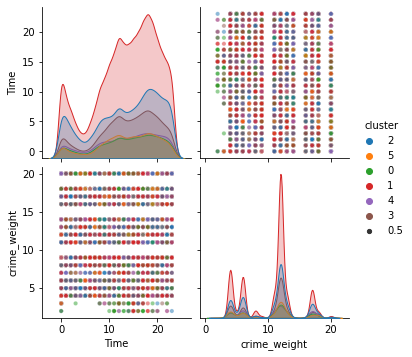

In [96]:
sns.pairplot(data=df,
             # Use kde for the diagonal subplots
             diag_kind='kde',
             hue='cluster',
             plot_kws=dict(
                 size=.5,
                 alpha=.5,
             ))

<BarContainer object of 7 artists>

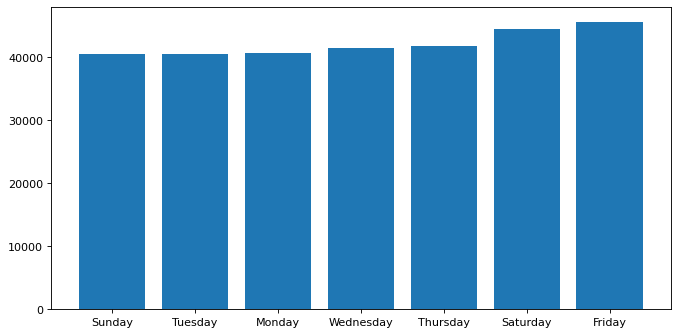

In [97]:
# get frequency of each day
cate_count_df = df.groupby('DayOfWeek').count().sort_values(by=['Time'])
fig, axes = plt.subplots(figsize=(10,5), dpi=80)
plt.bar(cate_count_df.index, cate_count_df.Time)

In [98]:
# cause as the previous plot shows, there is a slightly difference between Saturday&Friday vs the rest
df.loc[df['DayOfWeek'] == 'Saturday', 'DayOfWeek'] = 'weekend'
df.loc[df['DayOfWeek'] == 'Friday', 'DayOfWeek'] = 'weekend'
df.loc[df['DayOfWeek'] != 'weekend', 'DayOfWeek'] = 'weekday'

In [99]:
# encoded for regression model
encoded_df = pd.get_dummies(df)
encoded_df

,Time,crime_weight,DayOfWeek_weekday,DayOfWeek_weekend,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,20,13,1,0,0,0,1,0,0,0
1,18,12,1,0,0,0,0,0,0,1
2,21,12,1,0,1,0,0,0,0,0
3,13,11,1,0,0,1,0,0,0,0
4,13,12,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
294577,23,11,1,0,0,1,0,0,0,0
294578,17,13,1,0,0,1,0,0,0,0
294579,1,11,1,0,0,1,0,0,0,0
294580,20,17,0,1,0,1,0,0,0,0


In [100]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(encoded_df, test_size=0.2, random_state=1024)

x_train, x_test = train.copy().drop(columns='crime_weight'), test.copy().drop(columns='crime_weight')
y_train, y_test = train['crime_weight'], test['crime_weight']

## linear regression

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(x_train, y_train)
print("Model weights: ")
print(model.coef_)


y_test_pred = model.predict(x_test)


mse = mean_squared_error(y_test, y_test_pred)
print('Testing MSE: %8.15f' % mse)
model.score(x_train, y_train)
model.score(x_test, y_test)

NameError: name 'x_train' is not defined

In [19]:
# cross validation

## lasso regression

- here is a document talks about lasso model selection: AIC-BIC / cross-validation
https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html
- because we don't have many x variables, we could just use AIC or cross-validation for model selection (priority: cross-validation; if you don't have time, just forget about AIC lol)

In [20]:
# use the same datasets in linear regression section